# LEO Satellite Link Budget Analysis with Dynamic Distance

This notebook demonstrates the use of PyRadio to analyze uplink and downlink communication with a Low Earth Orbit (LEO) satellite. We'll calculate link margins at various distances using a mutable distance parameter and create plots to visualize the performance as the satellite moves in its orbit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyradio.antenna import Dish, FixedGain
from pyradio.link import Link
from pyradio.conversions import ghz, mhz, khz, kilometers

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['lines.linewidth'] = 2

## Create the Downlink and Uplink Models with Dynamic Distance

Let's create our downlink and uplink models using the PyRadio library. We'll use a mutable distance variable that will be accessed through a lambda function to make parameter sweeping easy.

In [2]:
# Mutable distance variable for parameter sweeping
current_distance_km = 800.0

# Create downlink model (satellite to ground)
downlink = Link(
    tx_power_dbw=3.0,  # 2W transmitter
    tx_antenna=FixedGain(2.0),  # Small omnidirectional antenna
    rx_antenna=Dish(diameter_m=5.0, efficiency=0.65),  # 5m dish on ground
    rx_system_noise_temp_k=120.0,  # Better cooling on ground
    rx_antenna_noise_temp_k=50.0,  # Earth background is warmer
    distance_fn=lambda: kilometers(current_distance_km),  # Lambda uses the mutable distance variable
    frequency_hz=ghz(2.25),  # S-band downlink
    bandwidth_hz=mhz(10.0),  # 10 MHz downlink bandwidth
    required_ebno_db=9.6,  # Required Eb/N0 for reliable comms
    implementation_loss_db=1.0,
    polarization_loss_db=0.5,
    pointing_loss_db=0.3,
    atmospheric_loss_db=0.2  # Low for S-band
)

# Create uplink model (ground to satellite)
uplink = Link(
    tx_power_dbw=13.0,  # 20W transmitter
    tx_antenna=Dish(diameter_m=5.0, efficiency=0.65),  # 5m dish on ground
    rx_antenna=FixedGain(2.0),  # Small omnidirectional antenna
    rx_system_noise_temp_k=450.0,  # Higher due to solar exposure
    rx_antenna_noise_temp_k=20.0,  # Cold space background
    distance_fn=lambda: kilometers(current_distance_km),  # Lambda uses the same mutable distance variable
    frequency_hz=ghz(2.075),  # S-band uplink
    bandwidth_hz=khz(256.0),  # 256 kHz uplink bandwidth (commands are narrower)
    required_ebno_db=9.6,  # Required Eb/N0 for reliable comms
    implementation_loss_db=1.0,
    polarization_loss_db=0.5,
    pointing_loss_db=0.3,
    atmospheric_loss_db=0.2  # Low for S-band
)

## Example Analysis at a Single Distance

Let's first analyze the uplink and downlink performance at a specific distance to understand the individual components.

In [3]:
# Set the distance to 800 km
current_distance_km = 800.0

# Print downlink budget
print("Downlink Budget (Satellite to Ground):")
print(f"Satellite EIRP: {downlink.eirp:.2f} dBW")
print(f"Path Loss: {downlink.path_loss_db:.2f} dB")
print(f"Received Power: {downlink.received_power_dbw:.2f} dBW")
print(f"System Noise Temperature: {downlink.system_noise_temperature_k:.2f} K")
print(f"Noise Power: {downlink.noise_power_dbw:.2f} dBW")
print(f"C/N Ratio: {downlink.carrier_to_noise_ratio_db:.2f} dB")
print(f"Eb/N0: {downlink.ebno_db():.2f} dB")
print(f"Required Eb/N0: {downlink.required_ebno_db:.2f} dB")
print(f"Link Margin: {downlink.link_margin_db():.2f} dB")
print()

# Print uplink budget
print("Uplink Budget (Ground to Satellite):")
print(f"Ground Station EIRP: {uplink.eirp:.2f} dBW")
print(f"Path Loss: {uplink.path_loss_db:.2f} dB")
print(f"Received Power: {uplink.received_power_dbw:.2f} dBW")
print(f"System Noise Temperature: {uplink.system_noise_temperature_k:.2f} K")
print(f"Noise Power: {uplink.noise_power_dbw:.2f} dBW")
print(f"C/N Ratio: {uplink.carrier_to_noise_ratio_db:.2f} dB")
print(f"Eb/N0: {uplink.ebno_db():.2f} dB")
print(f"Required Eb/N0: {uplink.required_ebno_db:.2f} dB")
print(f"Link Margin: {uplink.link_margin_db():.2f} dB")

Downlink Budget (Satellite to Ground):
Satellite EIRP: 5.00 dBW
Path Loss: 158.05 dB
Received Power: -113.99 dBW
System Noise Temperature: 170.00 K
Noise Power: -136.29 dBW
C/N Ratio: 22.30 dB
Eb/N0: 22.30 dB
Required Eb/N0: 9.60 dB
Link Margin: 11.70 dB

Uplink Budget (Ground to Satellite):
Ground Station EIRP: 51.86 dBW
Path Loss: 157.35 dB
Received Power: -103.99 dBW
System Noise Temperature: 470.00 K
Noise Power: -147.80 dBW
C/N Ratio: 43.80 dB
Eb/N0: 43.80 dB
Required Eb/N0: 9.60 dB
Link Margin: 33.20 dB


## Link Margin vs Distance Analysis

Now let's analyze how the link margin changes as the satellite distance varies from 400 km to 2000 km. We'll use the mutable distance variable with our existing Link objects.

In [4]:
# Define range of distances to analyze (in km)
distances_km = np.linspace(400, 2000, 100)  # 400 km to 2000 km

# Calculate link margins for different distances
downlink_margins = []
uplink_margins = []
path_losses = []

for distance in distances_km:
    # Update the distance variable (used by both link models via the lambda)
    current_distance_km = distance
    
    # Calculate and store metrics
    downlink_margins.append(downlink.link_margin_db())
    uplink_margins.append(uplink.link_margin_db())
    path_losses.append(downlink.path_loss_db)  # Path loss is almost identical for up/downlink

# Convert to numpy arrays
downlink_margins = np.array(downlink_margins)
uplink_margins = np.array(uplink_margins)
path_losses = np.array(path_losses)

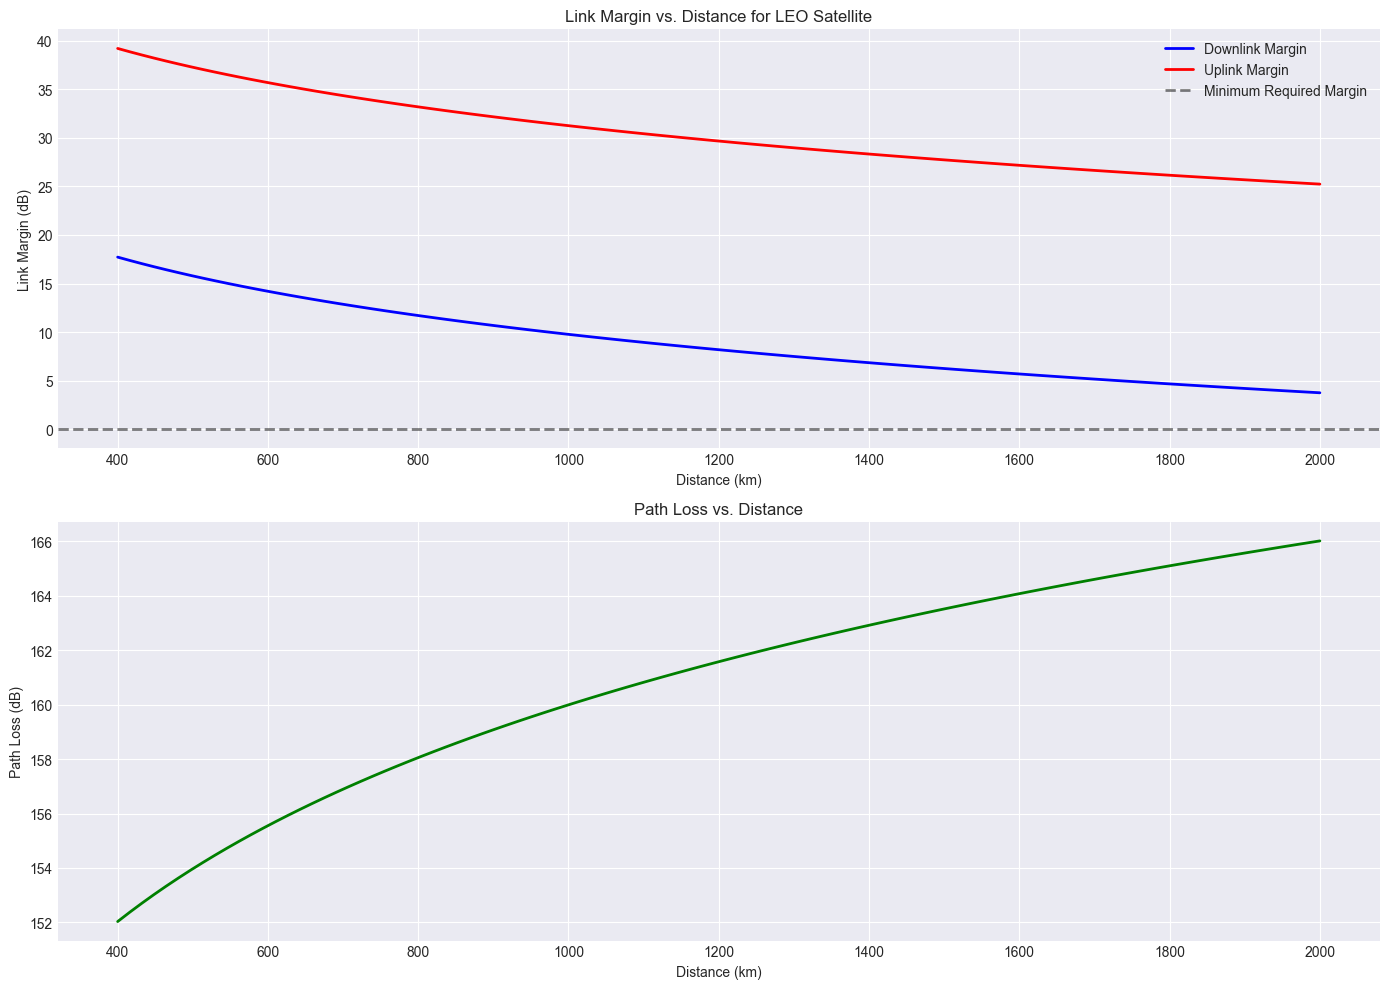

In [5]:
# Plot the link margins vs distance
plt.figure(figsize=(14, 10))

# First subplot: Link margins
plt.subplot(2, 1, 1)
plt.plot(distances_km, downlink_margins, 'b-', label='Downlink Margin')
plt.plot(distances_km, uplink_margins, 'r-', label='Uplink Margin')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5, label='Minimum Required Margin')
plt.grid(True)
plt.xlabel('Distance (km)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin vs. Distance for LEO Satellite')
plt.legend()

# Second subplot: Path loss
plt.subplot(2, 1, 2)
plt.plot(distances_km, path_losses, 'g-')
plt.grid(True)
plt.xlabel('Distance (km)')
plt.ylabel('Path Loss (dB)')
plt.title('Path Loss vs. Distance')

plt.tight_layout()
plt.show()

## Analyzing Maximum Range

Let's find the maximum range at which we still have a positive link margin for both uplink and downlink.

In [6]:
# Find where margins cross zero (if they do within our distance range)
downlink_max_range = None
uplink_max_range = None

# Function to find zero crossing
def find_zero_crossing(distances, margins):
    for i in range(len(margins)-1):
        if margins[i] > 0 and margins[i+1] < 0:
            # Linear interpolation to find exact crossing
            ratio = margins[i] / (margins[i] - margins[i+1])
            return distances[i] + ratio * (distances[i+1] - distances[i])
    # If no crossing, return None if all negative, or max distance if all positive
    if margins[-1] > 0:
        return distances[-1]  # All margins are positive
    return None  # All margins are negative

downlink_max_range = find_zero_crossing(distances_km, downlink_margins)
uplink_max_range = find_zero_crossing(distances_km, uplink_margins)

print("Maximum Operational Ranges:")
if downlink_max_range:
    print(f"Downlink: {downlink_max_range:.1f} km")
else:
    print("Downlink: Negative margin across entire range")
    
if uplink_max_range:
    print(f"Uplink: {uplink_max_range:.1f} km")
else:
    print("Uplink: Negative margin across entire range")
    
print(f"\nRange Limitation: {'Downlink' if downlink_max_range and (uplink_max_range is None or downlink_max_range < uplink_max_range) else 'Uplink'} limited")

Maximum Operational Ranges:
Downlink: 2000.0 km
Uplink: 2000.0 km

Range Limitation: Uplink limited


## Impact of Bandwidth on Link Margin

Let's investigate how changing the downlink bandwidth affects the link margin at a fixed distance of 1000 km.

Maximum bandwidth with positive margin at 1000 km: 85.3 MHz


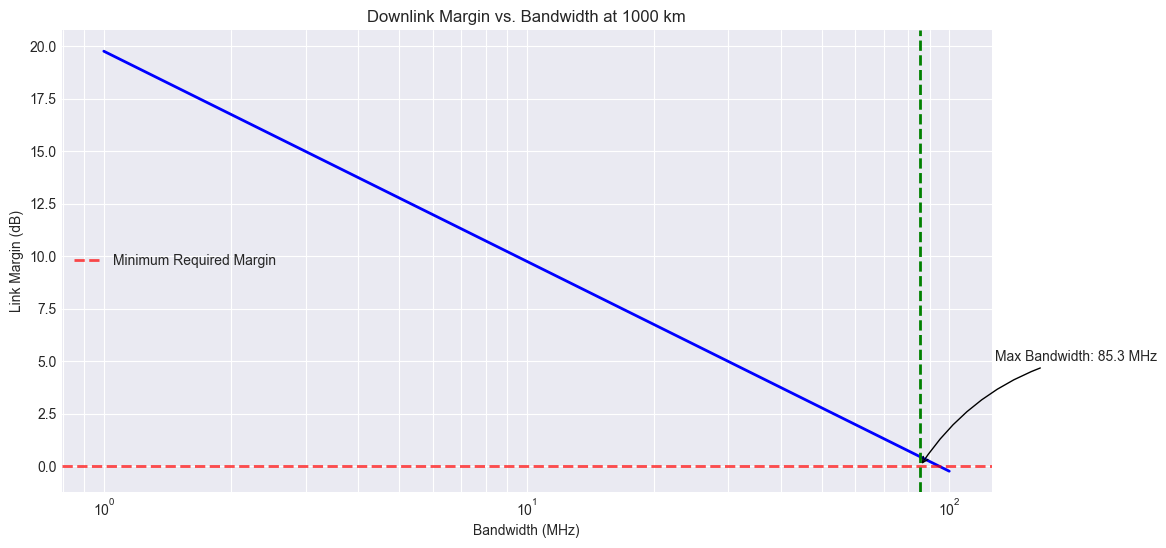

In [7]:
# Set a fixed distance for bandwidth analysis
current_distance_km = 1000

# Define a range of bandwidths to test
bandwidths_mhz = np.logspace(0, 2, 30)  # 1 MHz to 100 MHz
margins = []

# Save the original bandwidth value
original_bandwidth = downlink.bandwidth_hz

# Calculate margins for different bandwidths
for bw in bandwidths_mhz:
    # Temporarily modify the bandwidth
    downlink.bandwidth_hz = mhz(bw)
    margins.append(downlink.link_margin_db())

# Restore original bandwidth
downlink.bandwidth_hz = original_bandwidth

# Plot the results
plt.figure(figsize=(12, 6))
plt.semilogx(bandwidths_mhz, margins, 'b-')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7, label='Minimum Required Margin')
plt.grid(True, which='both')
plt.xlabel('Bandwidth (MHz)')
plt.ylabel('Link Margin (dB)')
plt.title(f'Downlink Margin vs. Bandwidth at {current_distance_km} km')
plt.legend()

# Find the maximum bandwidth with positive margin
max_bw_index = np.argmax(np.array(margins) < 0)
if max_bw_index > 0:
    max_bw = bandwidths_mhz[max_bw_index-1]
    plt.axvline(x=max_bw, color='g', linestyle='--')
    plt.annotate(f'Max Bandwidth: {max_bw:.1f} MHz', 
                 xy=(max_bw, 0), 
                 xytext=(max_bw*1.5, 5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
    print(f"Maximum bandwidth with positive margin at {current_distance_km} km: {max_bw:.1f} MHz")
else:
    print("All tested bandwidths have positive margin")

plt.show()

## Conclusion

In this notebook, we've analyzed the communication links for a LEO satellite system:

1. We computed and compared uplink and downlink margins across a range of distances
2. We determined the maximum operational range for both links
3. We investigated how bandwidth affects the downlink margin at a fixed distance

Key findings:
- The uplink generally has a higher margin than the downlink due to the higher transmitter power and antenna gain at the ground station
- Path loss increases logarithmically with distance, as expected
- Bandwidth has a significant impact on the link margin, with higher bandwidths reducing the margin

This analysis demonstrates the power of PyRadio's distance_fn callable for parameter sweeping. By using a mutable distance variable, we can efficiently analyze system performance across a range of distances using a single Link object instance, rather than recreating the model for each distance.